## Introduction

**[Tweet Sentiment Extraction](https://www.kaggle.com/competitions/tweet-sentiment-extraction)** is a Natural Language Processing (NLP) machine learning problem that was posted on **Kaggle**  as a Data Science Competition (2020).

In this notebook a baseline is created that demonstrates how such a problem of tweet sentiment extraction can be approached. A version of this notebook was used to participate in the NLP competition, and it secured a solo **[ranking of 966 out of 2227 participants (Top 44%)](https://www.kaggle.com/sangayb)**.
Below we provide a brief overview of what's to be expected from the notebook.

## Overview

**Description of the problem**: 
Given a tweet and its sentiment, which words or phrases best describe the sentiment. 

**Objective:**
Construct a machine learning model that will look at the labelled sentiment of the tweet and determine which words or phrases best supports the sentiment. 

**Data Description**:
The data comprises of csv files: training (`train.csv`) and testing (`test.csv`).  Each csv file contains the following columns: 
1. `textID` - unique ID for each piece of text
2. `text` - text of the tweet
3. `sentiment` - general sentiment of the tweet
4. `selected_text` - words or phrases in `text` that best describes the sentiment. 

**Approach:**
* Formulate the problem like a **Question-Answering** type NLP problem.
* Portion of the  `train.csv` dataset is used to train and validate the machine learning model. 

**Salient features** of this formulation are:

1. Preprocessesing the `train.csv` dataset:
   - Cleans the training dataset
   - Splits the `train.csv` data and use it for training and validation.  
   - Record the position of the `selected_text` within the `text` by denoting a starting and ending index.
2. Load the preprocessed csv-file to HuggingFace's [data.datasets](https://huggingface.co/docs/datasets/v1.2.1/loading_datasets.html). 
3. Then load it to a `tensorflow dataset` using the `.to_tf_dataset()` method.
3. Model
   - Finetuning a pretrained NLP model (RoBERTa) with a classification head on top -- RoBERTa is chosen over BERT because roBERTa tokenizer is better at handling special characters (`/`, `.`, etc) like those found in URL's. 

**Backend:** Keras Tensorflow


**References:**
1. https://huggingface.co/docs/transformers/preprocessing
2. Fine-tune a pretrained model https://huggingface.co/docs/transformers/training

3. Tensorflow Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
4. [Chris Deotte's amazing starter notebook - Tensorflow RoBERTa:](https://www.kaggle.com/code/cdeotte/tensorflow-roberta-0-705)

___

 ## Initiate `cpu` or `gpu` depending on the availablity 

In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy() 
else: 
    strategy = tf.distribute.get_strategy()
    

2022-10-02 20:44:24.622422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 20:44:24.766170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 20:44:24.770466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 20:44:24.782821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Import libraries

In [2]:
import os
import warnings
import numpy as np 
import pandas as pd 
import tensorflow as tf
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenizer

In [3]:
pretrained_model_name_or_path = 'roberta-base'
tknzer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, 
                                      add_prefix_space=True)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

## DATA PREPROCESSING

In [4]:
class Preprocessing():
    '''
    Features:
    1. Drop  NaN's.
    2. Drop all those tweets for which tokens of `selected_text` don't match with that of the `text`.
    3. Return the position of the first and last tokens of `selected_text` in the `text`.
    '''
    
    def __init__(
        self, 
        test_size = 0.01, # Default: 1.0%
        sample_size=5000, 
        random_state=100
    ):        

        self.path = '../input/tweet-sentiment-extraction'
        self.sample_size = sample_size
        self.test_size = test_size
        self.random_state = random_state
        self.csv_file = self.read_csv()
        
    def read_csv(self):
        train_csv = pd.read_csv(self.path + '/train.csv') 
        len0 = len(train_csv)
        train_csv = train_csv.dropna().reset_index(drop=True)
        print('Number of NaNs = ', len0 - len(train_csv))
        return train_csv


    def get_pos(self, text, selected_text):
        '''
        Returns starting and ending indical position of selected_text in the text.
        Note: Tokenizer adds a space at the beginning of the tokens. 
        '''
        text_ids = tknzer.encode(text)
        selected_text_ids = tknzer.encode(selected_text, add_special_tokens=False)

        a = 0; b = len(text_ids)
        for select_id in selected_text_ids: 
            for i in range(a, b):
                if select_id == text_ids[i]:
                    if a == 0:
                        start = i
                    end = i  
                    a = i + 1
                    break
        return (start, end) #, tknzer.decode(text_ids[start:end + 1]))

    def get_bad_indices(self):
        '''
         Collect all indices for which tokens of `selected_text` don't match with that of the `text`.
        '''
        bad_indices = []
        
        # label_start - Position in the text indicating the start of selected_text.
        # label_end - Position in the text indicating the end of selected_text.

        label_start = [] 
        label_end = []
        
        for n in range(len(self.csv_file)):
            text = self.csv_file.text[n]
            selected_text = self.csv_file.selected_text[n]
            try:
                start, end = self.get_pos(text, selected_text)
                label_start.append([start])
                label_end.append([end])
            except UnboundLocalError:
                bad_indices.append(n)
                
        return bad_indices, label_start, label_end
                       
    def get_clean_data(self):
        bad_indices, label_start, label_end = self.get_bad_indices()            
        self.csv_file = self.csv_file.drop(bad_indices).reset_index(drop=True)
        self.csv_file['label_start'] =  label_start
        self.csv_file['label_end'] = label_end
        return self.csv_file

    def split_data(self):
        '''Split sample into train and validation dataset'''
        
        full_data = self.get_clean_data()
        
        print('--'*20)
        print('AVAILABLE DATA SIZE:', len(full_data))
        print('--'*20)

        print('SAMPLE SIZE:', self.sample_size)
        
        sample_data = full_data[:self.sample_size].copy()

        test_sample_size = int(self.test_size*self.sample_size)
        test_csv = sample_data.sample(test_sample_size, random_state = self.random_state)
        train_csv = sample_data[~sample_data.index.isin(test_csv.index)].reset_index(drop=True)
        test_csv = test_csv.reset_index(drop=True)

        print('Training size:', train_csv.shape[0])
        print('Validating size:', test_csv.shape[0])
        print('--'*20)
        return train_csv, test_csv

# Sample size of only 5,000 out of 27,363 tweets will be utilized for training and validation...
train_csv, val_csv = Preprocessing(test_size=.01).split_data()

train_csv.head()

Number of NaNs =  1
----------------------------------------
AVAILABLE DATA SIZE: 27363
----------------------------------------
SAMPLE SIZE: 5000
Training size: 4950
Validating size: 50
----------------------------------------


,textID,text,selected_text,sentiment,label_start,label_end
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,[1],[10]
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,[1],[4]
2,088c60f138,my boss is bullying me...,bullying me,negative,[4],[5]
3,9642c003ef,what interview! leave me alone,leave me alone,negative,[4],[6]
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,[1],[4]


## Load dataset

In [5]:
def load_dataset(dataframe, shuffle, BATCH_SIZE = 20):
    
    from datasets import Dataset
    dataset = Dataset.from_pandas(dataframe)

    def tokenize(data):
        encode = tknzer(data['text'], data['sentiment']) 
        return encode

    dataset = dataset.map(tokenize)

    # Convert to tf.dataset
    def collate_fn(data, MAX_LEN=100):            
        inp_ids = [x['input_ids'] for x in data] #tt_ids = [x['token_type_ids'] for x in data]
        atten_msk = [x['attention_mask'] for x in data]

        label_start = []
        label_end = []
        for x in data:
            start = [0] * MAX_LEN
            a = x['label_start'][0]
            b = x['label_end'][0]
            start[a] = 1. 
            end = [0] * MAX_LEN
            end[b] = 1.
            label_start.append(start)
            label_end.append(end)

        inp_ids_p = pad_sequences(sequences=inp_ids, maxlen=MAX_LEN, padding='post') #tt_ids_p = pad_sequences(sequences=tt_ids, maxlen=MAX_LEN, padding='post')
        atten_msk_p = pad_sequences(sequences=atten_msk, maxlen=MAX_LEN, padding='post')

        return {
            'input_ids': inp_ids_p, 'attention_mask': atten_msk_p, 
            'label_start': label_start, 'label_end': label_end
        }
        
    tf_ds = dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'], 
        batch_size=BATCH_SIZE, 
        shuffle=shuffle, 
        collate_fn=collate_fn, 
        label_cols = ['label_start', 'label_end']
    )
    return tf_ds

train_ds = load_dataset(train_csv, shuffle=True)
val_ds = load_dataset(val_csv, shuffle=False)

  0%|          | 0/4950 [00:00<?, ?ex/s]

  0%|          | 0/50 [00:00<?, ?ex/s]

## model

In [6]:
class MyModel(tf.keras.Model):
    
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained_model = pretrained_model 
        
        self.dense1a = tf.keras.layers.Dense(1024)
        self.dense2a = tf.keras.layers.Dense(1)
        
        self.dense1b = tf.keras.layers.Dense(1024)
        self.dense2b = tf.keras.layers.Dense(1)
        
        self.flatten = tf.keras.layers.Flatten()
        self.activation = tf.keras.layers.Activation('softmax') 
    
    def call(self, inputs):  
        
        x = self.pretrained_model(inputs).last_hidden_state 
            
        x1 = self.dense2a(x)         
        x1 = self.flatten(x1)       
        x1 = self.activation(x1)  

        x2 = self.dense2b(x)       
        x2 = self.flatten(x2) 
        x2 = self.activation(x2)  
        
        return {'label_start': x1, 'label_end': x2}
 

## main

### train

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
2022-10-02 20:45:29.598120: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sha

Epoch 1/5
247/247 [==============================] - ETA: 0s - loss: 2.5508 - label_end_loss: 1.3376 - label_start_loss: 1.2132

2022-10-02 20:47:06.393214: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



247/247 [==============================] - 103s 305ms/step - loss: 2.5508 - label_end_loss: 1.3376 - label_start_loss: 1.2132 - val_loss: 1.9155 - val_label_end_loss: 0.9244 - val_label_start_loss: 0.9911
Epoch 2/5
247/247 [==============================] - 69s 281ms/step - loss: 1.7069 - label_end_loss: 0.8526 - label_start_loss: 0.8543 - val_loss: 1.8208 - val_label_end_loss: 0.8556 - val_label_start_loss: 0.9652
Epoch 3/5
247/247 [==============================] - 69s 279ms/step - loss: 1.3902 - label_end_loss: 0.6991 - label_start_loss: 0.6911 - val_loss: 1.8347 - val_label_end_loss: 0.9148 - val_label_start_loss: 0.9199
Epoch 4/5
247/247 [==============================] - 69s 279ms/step - loss: 1.1390 - label_end_loss: 0.5652 - label_start_loss: 0.5738 - val_loss: 2.3500 - val_label_end_loss: 1.1066 - val_label_start_loss: 1.2434
Epoch 5/5
247/247 [==============================] - 69s 279ms/step - loss: 0.9160 - label_end_loss: 0.4629 - label_start_loss: 0.4530 - val_loss: 2.9382

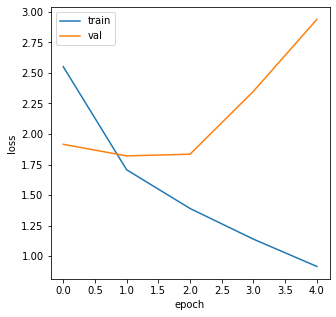

In [7]:
with strategy.scope():
    
    pretrained_model_name_or_path = 'roberta-base'
    pretrained_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path)
    model = MyModel(pretrained_model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # If one-hot encode, then use CategoricalCrossEntropy(), else SparseCategorical CrossEntropy())
    model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = [loss, loss]) 


# Train the model
h = model.fit(train_ds, epochs=5, validation_data = val_ds)

# Plot the training loss
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### predict

In [8]:
# Competition Metric: jaccard string
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [9]:
pred = model.predict(val_ds)
pred_start = pred['label_start']
pred_end = pred['label_end']

jaccard_score = []
predictions = []

for i, (p_start, p_end) in enumerate(zip(pred_start, pred_end)):
    start, end = tf.math.argmax(p_start, 0), tf.math.argmax(p_end, 0)   
    
    encode = tknzer.encode(val_csv.text[i])
    # Compute jaccard score
    pred_str = tknzer.decode(encode[start:end + 1])
    true_str = val_csv['selected_text'].iloc[i]    
    jaccard_score.append(jaccard(true_str, pred_str))
    predictions.append(pred_str)

print('-'*25)  
print('Avg. Jaccard Score = ', np.mean(jaccard_score))
print('-'*25)  
val_csv['prediction'] = predictions
val_csv['jaccard score'] = jaccard_score
val_csv.to_csv('test.csv', index=False)
val_csv = val_csv.drop(['label_start', 'label_end'], axis=1)
val_csv.head(25)


2022-10-02 20:52:28.909005: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



-------------------------
Avg. Jaccard Score =  0.6586794316794317
-------------------------


,textID,text,selected_text,sentiment,prediction,jaccard score
0,0d32a589d2,_Lay aww well I just randomly woke up and now ...,aww,negative,can`t sleep!,0.000000
1,29ffd15818,"she`s in LA, wanting sun today... but apparen...",A isn`t cooperating,negative,apparently LA isn`t cooperating,0.400000
2,fa9b70a1f3,Because of the new #Kirk. That`s why. Because...,Because of the new #Kirk. That`s why. Because ...,neutral,Because of the new #Kirk. That`s why. Because...,1.000000
3,a4388ba674,how i wish the result IS true...,how i wish the result IS true...,neutral,how i wish the result IS true...,1.000000
4,57dcad6611,hey Phillll! Wazzuppppp?!,hey Phillll! Wazzuppppp?!,neutral,hey Phillll! Wazzuppppp?!,1.000000
5,99b75adc3b,Yes... today is Star Wars Day! May the 4th ...,May the 4th be with you,positive,Yes... today is Star Wars Day!,0.000000
6,68927ebd21,ohh yeahh with the showcase he said his artis...,ohh yeahh with the showcase he said his artist...,neutral,ohh yeahh with the showcase he said his artis...,1.000000
7,3696d1db81,comes home in two days,comes home in two days,neutral,comes home in two days,1.000000
8,4f45d9a670,"It`s pretty good, actually! A few lame episod...","It`s pretty good, actually! A few lame episode...",neutral,"It`s pretty good, actually! A few lame episod...",1.000000
9,9c7bb80379,You know we do!,You know we do!,neutral,You know we do!,1.000000


# Concluding Remarks

* Only a fraction of the `train.csv` dataset was used to train the model. 
* Much higger score can be achieved by training over the whole dataset, and tinkering around the model head formulation. 
